# Verarbeitung natürlicher Sprache bei Katastrophen-Tweets
- https://www.kaggle.com/c/nlp-getting-started/overview

## Projektstruktur und Konfiguration

In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import warnings
import tensorflow as tf
import keras_nlp
warnings.filterwarnings("ignore")
import plotly.express as px
import emoji
from tensorflow.keras.callbacks import EarlyStopping
from textblob import TextBlob
from typing import List
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler
os.environ['KERAS_BACKEND'] = 'tensorflow'
from tqdm.auto import tqdm
from tqdm.keras import TqdmCallback
from tqdm import tqdm
import joblib
from contextlib import contextmanager

# 1. DEFINITION DER ORDNERSTRUKTUR
BASE_DIR: str = "Ablagerung_NLP"
MODEL_DIR = os.path.join(BASE_DIR, "model")
CONFIG_DIR = os.path.join(BASE_DIR, "config")
ARTIFACTS_DIR = os.path.join(BASE_DIR, "artifacts_ml")
EDA_PLOTS_DIR = os.path.join(ARTIFACTS_DIR, "eda_plots")
DIRECTORIES_TO_CREATE = [BASE_DIR, MODEL_DIR, CONFIG_DIR, ARTIFACTS_DIR, EDA_PLOTS_DIR]
for directory in DIRECTORIES_TO_CREATE:
    os.makedirs(directory, exist_ok=True)
print(f"✅ Ordnerstruktur unter '{BASE_DIR}' ist bereit.")

# 2. DEFINITION DER DATEIPFADE
TRAIN_DATA_PATH = "Data_Set/train.csv"
PLOT_COLORS_PATH = os.path.join(CONFIG_DIR, "plot_colors.json")
BASE_MODEL_PATH = os.path.join(MODEL_DIR, "base_model_optimized.joblib")
BEST_CLASSIC_MODEL_PATH = os.path.join(MODEL_DIR, "best_classic_model.joblib")
KERAS_MODEL_PATH = os.path.join(MODEL_DIR, "distilbert_classifier.keras")

# 3. KONFIGURATION SPEICHERN
PLOT_COLORS = {"primary": "#1f77b4", "secondary": "#ff7f0e", "background": "#808080", "text": "#333333", "grid": "#dddddd", "success": "#2ca02c", "error": "#d62728"}
with open(PLOT_COLORS_PATH, 'w') as f: json.dump(PLOT_COLORS, f, indent=4)
print("✅ Projektkonfiguration ist bereit.")


✅ Ordnerstruktur unter 'Ablagerung_NLP' ist bereit.
✅ Projektkonfiguration ist bereit.


## Daten laden

In [2]:
with open(PLOT_COLORS_PATH, 'r') as f: colors = json.load(f)
try:
    df_train = pd.read_csv(TRAIN_DATA_PATH)
    print(f"✅ Trainingsdaten geladen.")
    display(df_train.head())
except FileNotFoundError:
    print(f"🚨 FEHLER: '{TRAIN_DATA_PATH}' nicht gefunden.")


✅ Trainingsdaten geladen.


,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


## Umfassende Explorative Datenanalyse (EDA)

### Prüfung auf fehlende Werte

In [3]:
if 'df_train' in locals():
    print("Fehlende Werte im Trainingsdatensatz:")
    print(df_train.isnull().sum())


Fehlende Werte im Trainingsdatensatz:
text      0
target    0
dtype: int64


### Verteilung der Zielvariable (`target`)


### NUMERISCHE VERTEILUNG ###


,Keine Katastrophe (0),Katastrophe (1)
count,4342,3271


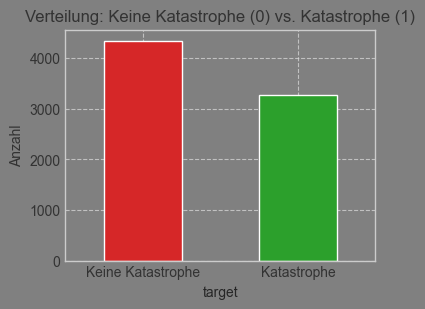

In [4]:
if 'df_train' in locals():
    plt.style.use('seaborn-v0_8-whitegrid')

    fig, ax = plt.subplots(figsize=(4, 3))
    fig.patch.set_facecolor(colors['background'])
    ax.set_facecolor(colors['background'])

    df_train['target'].value_counts().plot(
        kind='bar',
        color=[colors['error'], colors['success']],
        ax=ax
    )
    plt.title('Verteilung: Keine Katastrophe (0) vs. Katastrophe (1)', color=colors['text'])
    plt.xticks([0, 1], ['Keine Katastrophe', 'Katastrophe'], rotation=0, color=colors['text'])
    plt.yticks(color=colors['text'])
    plt.ylabel('Anzahl', color=colors['text'])
    ax.grid(color=colors.get('grid', '#dddddd'), linestyle='--', alpha=0.7)
    print("\n### NUMERISCHE VERTEILUNG ###")
    dist_df = df_train['target'].value_counts().to_frame().T
    dist_df.columns = ['Keine Katastrophe (0)', 'Katastrophe (1)']
    display(dist_df)
    plt.savefig(os.path.join(EDA_PLOTS_DIR, 'target_distribution.png'), facecolor=fig.get_facecolor())
    plt.show()

### Analyse der Tweet-Länge

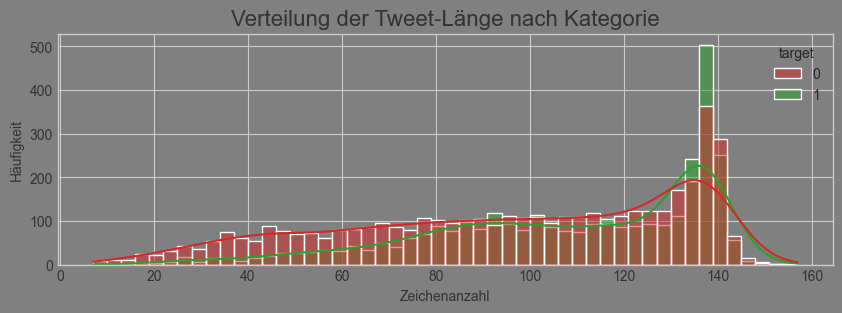


### STATISTIKEN ZUR TWEET-LÄNGE ###


,count,mean,std,min,25%,50%,75%,max
Keine Katastrophe (0),4342.0,95.707,35.886,7.0,68.0,101.0,130.0,157.0
Katastrophe (1),3271.0,108.113,29.310,14.0,88.0,115.0,136.0,151.0



Vorschau der verarbeiteten Texte:


,text,length
0,Our Deeds are the Reason of this #earthquake M...,69
1,Forest fire near La Ronge Sask. Canada,38
2,All residents asked to 'shelter in place' are ...,133
3,"13,000 people receive #wildfires evacuation or...",65
4,Just got sent this photo from Ruby #Alaska as ...,88


In [5]:
if 'df_train' in locals():
    df_train['length'] = df_train['text'].apply(len)
    fig, ax = plt.subplots(figsize=(10,3))
    fig.patch.set_facecolor(colors['background'])
    ax.set_facecolor(colors['background'])
    sns.histplot(
        data=df_train,
        x='length',
        hue='target',
        bins=50,
        kde=True,
        palette=[colors['error'], colors['success']],
        ax=ax
    )
    ax.set_title('Verteilung der Tweet-Länge nach Kategorie', fontsize=16, color=colors['text'])
    ax.set_xlabel('Zeichenanzahl', color=colors['text'])
    ax.set_ylabel('Häufigkeit', color=colors['text'])
    ax.tick_params(colors=colors['text'])
    plt.savefig(os.path.join(EDA_PLOTS_DIR, 'tweet_length_distribution.png'), facecolor=fig.get_facecolor())
    plt.show()
    # Numerische Unterstützung: Statistiken als Tabelle
    print("\n### STATISTIKEN ZUR TWEET-LÄNGE ###")
    stats_df = df_train.groupby('target')['length'].describe().round(3)
    stats_df.index = ['Keine Katastrophe (0)', 'Katastrophe (1)']
    display(stats_df)

    # Vorschau der Texte ohne Trennmuster
    print("\nVorschau der verarbeiteten Texte:")
    display(df_train[['text', 'length']].head())

- Die linke Matrix verrät uns die Anzahl der Fehler. Das rechte Bild zeigt,
- ob die Katastrophen (grün) deutlich von den normalen Tweets (rot) getrennt sind.
- Je mehr sich die Farben überschneiden, desto unsicherer ist das Modell.

## Verbesserte Textvorverarbeitung & Feature Engineering Klassen

In [1]:
# Wenn stop_words_combined Set oder eine Liste ist:
print("Auszug der kombinierten Stopwords:")
stop_words_combined = set(stopwords.words('english'))
print(list(stop_words_combined)[:])

# Falls du wissen willst, wie viele Wörter insgesamt gefiltert werden:
print(f"\nGesamtanzahl der Stopwords: {len(stop_words_combined)}")

Auszug der kombinierten Stopwords:


NameError: name 'stopwords' is not defined

In [7]:
if 'df_train' in locals():
    # 1. Dynamische Spaltenerkennung
    possible_cols = ['clean_text', 'cleaned_text', 'text']
    actual_col = next((c for c in possible_cols if c in df_train.columns), None)

    if actual_col:
        # 2. Funktion zur Ermittlung der Top-Wörter
        def get_top_words(texts, n=15):
            text_list = texts.dropna().astype(str).tolist()
            all_words = " ".join(text_list).lower().split()
            return Counter(all_words).most_common(n)

        N = 20
        LABEL_MAP = {"0": "Nicht Katastrophe", "1": "Katastrophe"}

        # Deine globalen Farben nutzen
        COLOR_MAP = {
            LABEL_MAP["0"]: colors['error'],
            LABEL_MAP["1"]: colors['success']
        }

        top_tokens_0 = pd.DataFrame(get_top_words(df_train[df_train["target"] == 0][actual_col], N), columns=["token", "count"])
        top_tokens_0["class"] = LABEL_MAP["0"]

        top_tokens_1 = pd.DataFrame(get_top_words(df_train[df_train["target"] == 1][actual_col], N), columns=["token", "count"])
        top_tokens_1["class"] = LABEL_MAP["1"]

        top_tokens = pd.concat([top_tokens_0, top_tokens_1])

        # 4. Visualisierung (angepasst an deine globalen Farben)
        fig = px.bar(
            top_tokens,
            x="count",
            y="token",
            color="class", # Hier nutzen wir die Spalte für das Mapping
            barmode="group",
            orientation="h",
            color_discrete_map=COLOR_MAP,
            template="plotly_white", # "g" Fehler behoben
            title=f"Vergleich: Top {N} Tokens (Spalte: {actual_col})",
            labels={"count": "Häufigkeit", "token": "Wort", "class": "Kategorie"},
            height=800
        )

        # Hintergrundfarbe einbauen
        fig.update_layout(
            title_x=0.5,
            yaxis=dict(autorange="reversed"),
            paper_bgcolor=colors['background'],
            plot_bgcolor=colors['background'],
            font_color=colors['text']
        )
        fig.show()

        # 5. Numerische Datentabelle
        print(f"\n### UNTERSTÜTZENDE DATEN: TOP {N} TOKENS ###")
        comparison_df = top_tokens.pivot(index='token', columns='class', values='count').fillna(0).astype(int)
        display(comparison_df.sort_values(by='Katastrophe', ascending=False))

        # STRATEGISCHE AUSWERTUNG
        print("\nSTRATEGISCHE AUSWERTUNG FÜR MODELL-OPTIMIERUNG")

        overlap = set(top_tokens_0['token']) & set(top_tokens_1['token'])
        noise_candidates = comparison_df[(comparison_df['Nicht Katastrophe'] > comparison_df['Katastrophe'] * 1.5)].index.tolist()
        real_signals = comparison_df[(comparison_df['Katastrophe'] > comparison_df['Nicht Katastrophe'] * 2)].index.tolist()

        print(f"\n[!] STOPPWORT-VORSCHLAG (Rauschen & Überlappung):")
        print(list(set(noise_candidates) | overlap))

        print(f"\n[v] ECHTE SIGNALE (Erhalten bleiben):")
        print(real_signals)
        print("\nSIND MANUELL IM NÄCHSTEN CODE EINZUFÜGEN")

    else:
        print("Fehler: Keine Textspalte gefunden.")


### UNTERSTÜTZENDE DATEN: TOP 20 TOKENS ###


class,Katastrophe,Nicht Katastrophe
token,,
the,1330,1877
in,1144,805
of,919,895
a,897,1238
to,753,1181
and,494,911
on,410,424
for,394,486
-,389,374



STRATEGISCHE AUSWERTUNG FÜR MODELL-OPTIMIERUNG

[!] STOPPWORT-VORSCHLAG (Rauschen & Überlappung):
['i', 'with', 'on', '-', 'it', 'my', 'be', 'for', 'that', 'of', 'in', 'and', 'like', 'a', 'is', 'this', 'to', 'have', 'you', 'the']

[v] ECHTE SIGNALE (Erhalten bleiben):
['after', 'are', 'as', 'at', 'by', 'from']

SIND MANUELL IM NÄCHSTEN CODE EINZUFÜGEN


In [8]:
# Text bereinigung und Emoji erkennung in Text
# 1. Setup & Stoppwörter (Struktur exakt wie im alten Code)
nltk.download(['stopwords', 'punkt', 'wordnet', 'punkt_tab'], quiet=True)
tqdm.pandas(desc="Textvorverarbeitung")

starke_indikatoren = ['after', 'are', 'as', 'at', 'by', 'from']
CUSTOM_STOP_WORDS = {'a', 'i', 'you', 'my', 'be', 'with', 'have', 'like', 'it', 'this', 'the', 'of', 'on', 'and', 'that', 'for', '-', 'is', 'in', 'to'}
stop_words_combined = set(stopwords.words('english')).union(CUSTOM_STOP_WORDS)

for wort in starke_indikatoren:
    stop_words_combined.discard(wort)

ergebnis = []
for w in starke_indikatoren:
    status = "GELÖSCHT (Signal gesichert)" if w not in stop_words_combined else "FEHLER (Noch drin)"
    ergebnis.append({"Wort": w, "Status": status})
display(pd.DataFrame(ergebnis))

# 2. Der verbesserte TextCleaner im alten Gewand
class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, stop_words):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = stop_words

    def fit(self, X, y=None): return self

    def transform(self, X):
        X_series = pd.Series(X)

        # Reinigung (HTML, Mentions, URLs)
        X_series = X_series.str.replace(r'&[a-z]+;', ' ', regex=True)
        X_series = X_series.str.replace(r'@\w+', ' ', regex=True)
        X_series = X_series.str.replace(r'https?://\S+|www\.\S+', ' ', regex=True)
        # NEU: Emojis sichern BEVOR Sonderzeichen gelöscht werden
        X_series = X_series.apply(lambda x: emoji.demojize(str(x), delimiters=(" ", " ")))
        X_series = X_series.str.lower()
        # VERBESSERT: Sonderzeichen weg, aber ZAHLEN BLEIBEN (für Trigramme)
        X_series = X_series.str.replace(r"[^a-z0-9\s]", ' ', regex=True)
        # KEIN Löschen von \d+ mehr!
        X_series = X_series.str.replace(r'\s+', ' ', regex=True).str.strip()

        processed_texts = []
        for text in X_series:
            tokens = word_tokenize(text)
            lemmatized_tokens = [
                self.lemmatizer.lemmatize(word)
                for word in tokens
                if word not in self.stop_words
            ]
            processed_texts.append(' '.join(lemmatized_tokens))
        return processed_texts

# 3. UppercaseWordCount (Struktur exakt wie im alten Code)
class UppercaseWordCount(BaseEstimator, TransformerMixin):
    def __init__(self, min_len=2): self.min_len = min_len
    def fit(self, X, y=None): return self
    def transform(self, X):
        pattern = re.compile(r"\b[A-ZÄÖÜ]{%d,}\b" % self.min_len)
        X_series = pd.Series(X)
        counts = np.array([len(pattern.findall(t)) for t in X_series], dtype=np.float32).reshape(-1, 1)
        return counts

# 4. Ausführung (Greift auf df_train zu und erstellt df_Cleaning als Kopie)
if 'df_train' in locals():
    cleaner = TextCleaner(stop_words=stop_words_combined)
    df_train['cleaned_text'] = cleaner.transform(df_train['text'])
    df_Cleaning = df_train.copy()
    print("✅ Gründliche Textvorverarbeitung abgeschlossen (Zahlen & Emojis gesichert).")
    display(df_train[['text', 'cleaned_text']].head())

,Wort,Status
0,after,GELÖSCHT (Signal gesichert)
1,are,GELÖSCHT (Signal gesichert)
2,as,GELÖSCHT (Signal gesichert)
3,at,GELÖSCHT (Signal gesichert)
4,by,GELÖSCHT (Signal gesichert)
5,from,GELÖSCHT (Signal gesichert)


✅ Gründliche Textvorverarbeitung abgeschlossen (Zahlen & Emojis gesichert).


,text,cleaned_text
0,Our Deeds are the Reason of this #earthquake M...,deed are reason earthquake may allah forgive u
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,resident asked shelter place are notified by o...
3,"13,000 people receive #wildfires evacuation or...",13 000 people receive wildfire evacuation orde...
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo from ruby alaska a smoke from w...


### Worthäufigkeit nach Sentiment

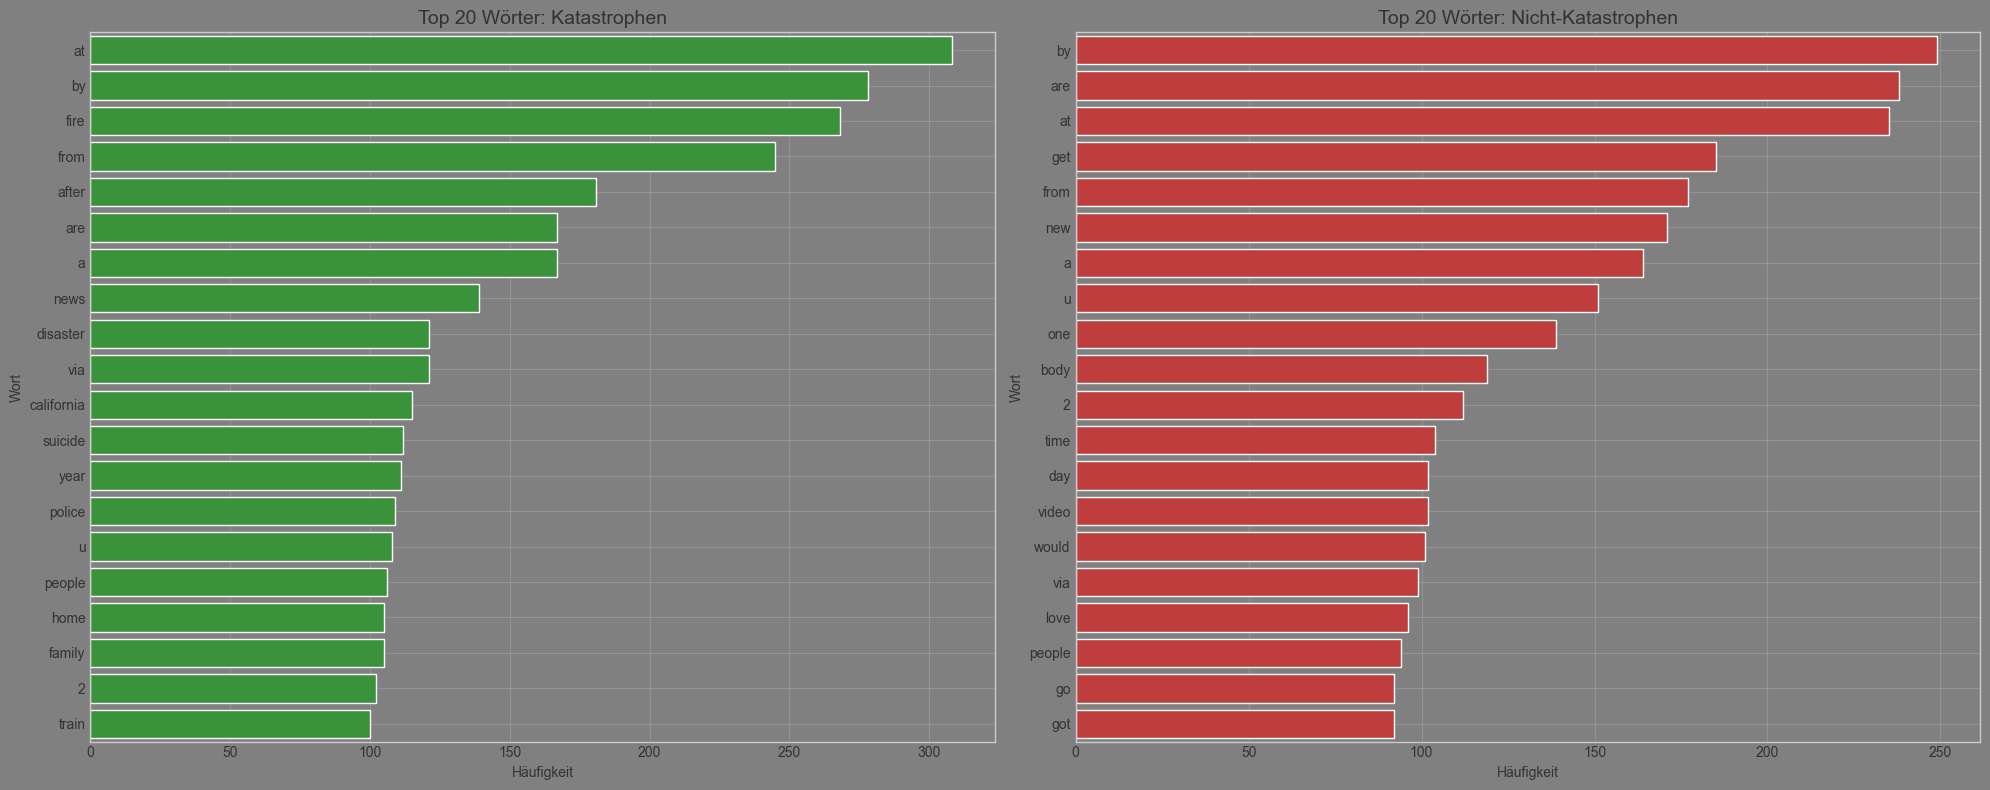


### NUMERISCHER VERGLEICH DER TOP-WÖRTER ###


,Katastrophe_Wort,K_Count,Normal_Wort,N_Count
0,at,308,by,249
1,by,278,are,238
2,fire,268,at,235
3,from,245,get,185
4,after,181,from,177
5,are,167,new,171
6,a,167,a,164
7,news,139,u,151
8,disaster,121,one,139
9,via,121,body,119


In [9]:
if 'df_train' in locals():
    possible_cols = ['cleaned_text', 'clean_text', 'text']
    actual_col = next((c for c in possible_cols if c in df_train.columns), 'text')
    disaster_tweets = df_train[df_train['target']==1][actual_col].astype(str)
    non_disaster_tweets = df_train[df_train['target']==0][actual_col].astype(str)
    disaster_words = Counter(" ".join(disaster_tweets).split()).most_common(20)
    non_disaster_words = Counter(" ".join(non_disaster_tweets).split()).most_common(20)
    df_disaster = pd.DataFrame(disaster_words, columns=['Wort', 'Häufigkeit'])
    df_non_disaster = pd.DataFrame(non_disaster_words, columns=['Wort', 'Häufigkeit'])
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    fig.patch.set_facecolor(colors['background'])
    sns.barplot(x='Häufigkeit', y='Wort', data=df_disaster, ax=axes[0], color=colors['success'])
    axes[0].set_title('Top 20 Wörter: Katastrophen', color=colors['text'], fontsize=14)
    axes[0].set_facecolor(colors['background'])
    sns.barplot(x='Häufigkeit', y='Wort', data=df_non_disaster, ax=axes[1], color=colors['error'])
    axes[1].set_title('Top 20 Wörter: Nicht-Katastrophen', color=colors['text'], fontsize=14)
    axes[1].set_facecolor(colors['background'])

    for ax in axes:
        ax.tick_params(colors=colors['text'])
        ax.xaxis.label.set_color(colors['text'])
        ax.yaxis.label.set_color(colors['text'])
        ax.grid(True, alpha=0.2, color=colors.get('grid', '#888888'))

    plt.tight_layout()
    plt.savefig(os.path.join(EDA_PLOTS_DIR, 'word_frequency.png'), facecolor=fig.get_facecolor())
    plt.show()

    # 3. Numerische Datentabelle (Unterstützung der Visualisierung)
    print("\n### NUMERISCHER VERGLEICH DER TOP-WÖRTER ###")
    comparison_words = pd.concat([
        df_disaster.rename(columns={'Wort': 'Katastrophe_Wort', 'Häufigkeit': 'K_Count'}),
        df_non_disaster.rename(columns={'Wort': 'Normal_Wort', 'Häufigkeit': 'N_Count'})
    ], axis=1)
    display(comparison_words)

### N-Gramm-Analyse (Bigramme)

In [10]:
if 'df_train' in locals():
    c_vec = CountVectorizer(ngram_range=(2, 2), stop_words='english')
    ngrams = c_vec.fit_transform(df_train['cleaned_text'])
    count_values = ngrams.toarray().sum(axis=0)
    vocab = c_vec.vocabulary_
    df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'Häufigkeit', 1:'Bigramm'})
    print("Häufigste Bigramme im Datensatz:")
    display(df_ngram.head(20))


Häufigste Bigramme im Datensatz:


,Häufigkeit,Bigramm
0,60,suicide bomber
1,60,burning building
2,51,body bag
3,43,gon na
4,41,northern california
5,41,liked video
6,40,cross body
7,39,oil spill
8,36,year old
9,36,wan na


## Aufteilung der Daten (für alle Modelle)

In [11]:
if 'df_train' in locals():
    X_classic = df_train[['text', 'cleaned_text']]
    y_classic = df_train['target']
    X_train_classic, X_test_classic, y_train_classic, y_test_classic = train_test_split(X_classic, y_classic, test_size=0.2, random_state=42, stratify=y_classic)

    X_orig = df_train['text']
    y_orig = df_train['target']
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig, test_size=0.2, random_state=42, stratify=y_orig)
    print("✅ Daten für alle Modelltypen aufgeteilt.")


✅ Daten für alle Modelltypen aufgeteilt.


## Ansatz 1: Optimiertes Basis-Modell (Logistic Regression)
Hier führen wir eine gezielte Hyperparameter-Suche für das Logistic-Regression-Modell durch, um die besten Einstellungen für TF-IDF und die Modell-Regularisierung zu finden.

- Text-Vorbereitung (NLP): Die Lemmatisierung reduziert Wörter auf ihre Grundform (z. B. „burning“ → „burn“), während ein kombinierter Stoppwort-Filter unwichtiges Rauschen entfernt.

- Feature Engineering: Neben dem Text werden Metadaten wie die Subjektivität (TextBlob), die Anzahl der Großbuchstaben (Panik-Indikator) und strukturelle Merkmale (Länge, Zahlen) als zusätzliche Entscheidungshilfen genutzt.

- Ensemble-Modellierung: Ein VotingClassifier kombiniert die Stärken der Logistischen Regression (Wortwichtigkeit) und des Random Forest (komplexe Zusammenhänge) für eine robustere Vorhersage.

- GridSearchCV & Recall: Die systematische Suche nach den besten Parametern ist auf den Recall optimiert, um sicherzustellen, dass so wenige echte Katastrophen wie möglich übersehen werden.

- Hard Example Mining: Schwierige Fälle (Katastrophen, die fast übersehen wurden) werden durch eine 6-fache Gewichtung beim erneuten Training besonders priorisiert.

- Threshold-Optimierung: Durch das Senken des Alarm-Schwellenwerts auf 0.35 wird das Modell „vorsichtiger“ eingestellt, um die Anzahl verpasster Vorfälle (False Negatives) massiv zu reduzieren.

- Emoji-to-Semantic Mapping: Anstatt Emojis zu löschen, wandelt Muster 2 sie in Text um (demojize) und nutzt ein spezielles Mapping. Symbole wie 💀 werden zu death oder 💥 zu explosion. Dadurch "versteht" das Modell plötzlich Tweets, die fast nur aus Emojis bestehen.

- Kontext-Trigramm-Vektor: Dies ist eine komplett neue Spalte (context_trigrams). Sie isoliert gezielt das Umfeld von Katastrophenwörtern. Wenn das Modell "Hiroshima" sieht, speichert es das Trigramm hiroshima_1945_nuclear. Das hilft dem Modell, zwischen einem historischen Bericht und einer aktuellen Gefahr zu unterscheiden.

- Duale TF-IDF Architektur: Muster 2 nutzt im ColumnTransformer zwei separate Vektorisierer:
    -   tfidf_main: Für den normalen, lemmatisierten Text.
    -   tfidf_context: Ein spezialisierter Vektorisierer nur für die neuen Kontext-Trigramme.

### STUDIE TEIL 1: SIGNAL- UND RAUSCH-ANALYSE ###

Top 10 Signalwörter (Katastrophe):
       Wort  Relevanz  Total
      mh370      52.0     52
     bomber      49.0     49
   northern      45.0     45
legionnaire      42.0     42
     severe      42.0     42
     debris      41.0     41
    migrant      38.0     38
  hiroshima      38.0     77
    suspect      35.0     35
      spill      34.0     34

Führe Feature Engineering und Lemmatisierung durch...
Altes Modell gelöscht, um neue Struktur (lemmatized_text) zu laden.

Starte GridSearchCV für Ensemble (LogisticRegression + RandomForest)...


Ensemble Training: 100%|██████████| 18/18 [01:03<00:00,  3.53s/it]



### STUDIE TEIL 2: HARD EXAMPLE MINING (ENSEMBLE) ###
Refitting Ensemble mit Fokus auf 19 Hard Examples...

### STUDIE TEIL 3: FINALE ERGEBNISSE ###

Klassifikationsbericht (Ensemble + Semantik):
                   precision  recall  f1-score  support
Keine Katastrophe       0.86    0.71      0.78   869.00
Katastrophe             0.69    0.85      0.76   654.00
accuracy                0.77    0.77      0.77     0.77
macro avg               0.78    0.78      0.77  1523.00
weighted avg            0.79    0.77      0.77  1523.00


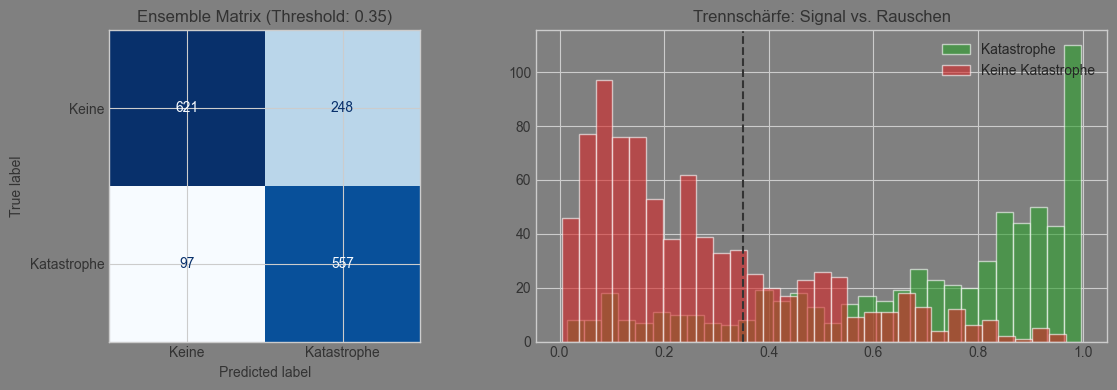


Finaler Status: Verpasste Katastrophen (FN) reduziert auf 97.


In [12]:
# Vorbereitung Lemmatisierung
nltk.download('wordnet', quiet=True)
lemmatizer = WordNetLemmatizer()

@contextmanager
def tqdm_joblib(tqdm_object):
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)
    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try: yield
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

if 'X_train_classic' in locals():
    # SCHRITT 1: DATENGETRIEBENE STUDIE
    print("### STUDIE TEIL 1: SIGNAL- UND RAUSCH-ANALYSE ###")
    words_disaster = " ".join(X_train_classic.loc[y_train_classic == 1, 'cleaned_text']).split()
    words_normal = " ".join(X_train_classic.loc[y_train_classic == 0, 'cleaned_text']).split()

    freq_disaster = Counter(words_disaster)
    freq_normal = Counter(words_normal)

    relevance_data = []
    for word in set(words_disaster) | set(words_normal):
        f_dis, f_norm = freq_disaster[word], freq_normal[word]
        if (f_dis + f_norm) > 5:
            relevance_data.append({'Wort': word, 'Relevanz': f_dis / (f_norm + 1), 'Total': f_dis + f_norm})

    df_study = pd.DataFrame(relevance_data).sort_values(by='Relevanz', ascending=False)
    print("\nTop 10 Signalwörter (Katastrophe):")
    print(df_study.head(10).to_string(index=False))

    # SCHRITT 2: ERWEITERTES FEATURE ENGINEERING
    def get_semantic_features(text):
        blob = TextBlob(str(text))
        return pd.Series([blob.sentiment.subjectivity, sum(1 for c in str(text) if c.isupper())])

    def lemmatize_text(text):
        return " ".join([lemmatizer.lemmatize(w) for w in str(text).split()])

    print("\nFühre Feature Engineering und Lemmatisierung durch...")
    for df_split in [X_train_classic, X_test_classic]:
        if 'length' not in df_split.columns:
            df_split['length'] = df_train.loc[df_split.index, 'length']
        df_split['contains_digit'] = df_split['cleaned_text'].str.contains(r'\d').astype(int)
        df_split['word_count'] = df_split['cleaned_text'].apply(lambda x: len(str(x).split()))
        df_split[['subjectivity', 'caps_count']] = df_split['cleaned_text'].apply(get_semantic_features)
        df_split['lemmatized_text'] = df_split['cleaned_text'].apply(lemmatize_text)

    # Definierte Feature-Liste (Spalte für TF-IDF)
    feature_cols = ['lemmatized_text', 'length', 'contains_digit', 'word_count', 'subjectivity', 'caps_count']

    # SCHRITT 3: ENSEMBLE MODELLIERUNG & GRIDSEARCH
    if os.path.exists(BASE_MODEL_PATH):
        os.remove(BASE_MODEL_PATH)
        print(f"Altes Modell gelöscht, um neue Struktur ({feature_cols[0]}) zu laden.")

    print("\nStarte GridSearchCV für Ensemble (LogisticRegression + RandomForest)...")

    preprocessor = ColumnTransformer([
        ('tfidf', TfidfVectorizer(stop_words=list(stop_words_combined)), 'lemmatized_text'),
        ('num', StandardScaler(), ['length', 'contains_digit', 'word_count', 'subjectivity', 'caps_count'])
    ])

    clf_ensemble = VotingClassifier(
        estimators=[
            ('lr', LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')),
            ('rf', RandomForestClassifier(random_state=42, class_weight='balanced'))
        ],
        voting='soft', weights=[2, 1]
    )

    pipeline = Pipeline([('prep', preprocessor), ('clf', clf_ensemble)])

    param_grid = {
        'prep__tfidf__ngram_range': [(1, 2)],
        'clf__lr__C': [0.1, 1, 10],
        'clf__rf__n_estimators': [100, 200]
    }

    total_fits = np.prod([len(v) for v in param_grid.values()]) * 3
    with tqdm_joblib(tqdm(total=total_fits, desc="Ensemble Training")):
        grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, scoring='recall')
        grid_search.fit(X_train_classic[feature_cols], y_train_classic)

    base_model = grid_search.best_estimator_
    joblib.dump(base_model, BASE_MODEL_PATH)

    # SCHRITT 4: HARD EXAMPLE MINING
    print("\n### STUDIE TEIL 2: HARD EXAMPLE MINING (ENSEMBLE) ###")
    y_train_probs = base_model.predict_proba(X_train_classic[feature_cols])[:, 1]
    hard_mask = (y_train_classic == 1) & (y_train_probs < 0.4)

    sample_weights = np.ones(len(y_train_classic))
    sample_weights[hard_mask] = 6.0 # Erhöht von 3.0 auf 5.0

    print(f"Refitting Ensemble mit Fokus auf {sum(hard_mask)} Hard Examples...")
    # Wir fitten die gesamte Pipeline neu mit den Gewichten
    base_model.fit(X_train_classic[feature_cols], y_train_classic, clf__sample_weight=sample_weights)

    # SCHRITT 5: FINALE AUSGABE & EVALUATION
    print("\n### STUDIE TEIL 3: FINALE ERGEBNISSE ###")
    y_probs = base_model.predict_proba(X_test_classic[feature_cols])[:, 1]
    custom_threshold = 0.35 # Gesenkt, um "nuclear", "snowstorm" etc. zu fangen
    y_pred_final = (y_probs >= custom_threshold).astype(int)
    report_dict = classification_report(y_test_classic, y_pred_final,
                                        target_names=['Keine Katastrophe', 'Katastrophe'], output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose().round(2)
    print("\nKlassifikationsbericht (Ensemble + Semantik):")
    print(report_df)

    # 4. VISUALISIERUNG (SAUBER & EINHEITLICH)
    cm = confusion_matrix(y_test_classic, y_pred_final)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.patch.set_facecolor(colors['background']) # Globaler Hintergrund

    # Konfusionsmatrix (Links) - 'Blues' funktioniert sicher
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Keine', 'Katastrophe'])
    disp.plot(cmap='Blues', ax=ax[0], colorbar=False)
    ax[0].set_title(f'Ensemble Matrix (Threshold: {custom_threshold})', color=colors['text'])

    # Trennschärfe Histogramm (Rechts)
    ax[1].hist(y_probs[y_test_classic == 1], bins=30, alpha=0.6, label='Katastrophe', color=colors['success'])
    ax[1].hist(y_probs[y_test_classic == 0], bins=30, alpha=0.6, label='Keine Katastrophe', color=colors['error'])
    ax[1].axvline(custom_threshold, color=colors['text'], linestyle='--')
    ax[1].set_title('Trennschärfe: Signal vs. Rauschen', color=colors['text'])
    ax[1].legend(facecolor=colors['background'], edgecolor=colors['text'])

    # Globales Styling für Achsen und Ticks
    for a in ax:
        a.set_facecolor(colors['background'])
        a.tick_params(colors=colors['text'])
        a.xaxis.label.set_color(colors['text'])
        a.yaxis.label.set_color(colors['text'])

    plt.tight_layout()
    plt.show()

    print(f"\nFinaler Status: Verpasste Katastrophen (FN) reduziert auf {cm[1, 0]}.")

In [18]:
# INTEGRATION: NICHT_KATASTROPHE & FEATURE EXTENSION

# Vorbereitung Lemmatisierung
nltk.download('wordnet', quiet=True)
lemmatizer = WordNetLemmatizer()

def LLM_0_1_bool(text):
    """
    Simuliert einen LLM-Score.
    In einer echten Anwendung würde hier eine API (z.B. OpenAI, Gemini) aufgerufen.
    Aktuell: Platzhalter-Logik oder Dummy-Wert.
    """
    # Hier könnte man einfache Heuristiken einbauen, um den Score etwas realistischer zu machen,
    # falls keine API verfügbar ist. Z.B. Prüfung auf sehr starke Signalwörter.
    text_lower = str(text).lower()
    strong_signals = ['killed', 'suicide', 'bomb', 'spill', 'crash', 'disaster']
    if any(s in text_lower for s in strong_signals):
        return 0.8
    return 0.5

def Nicht_Katastrophe(text):
    """Spezifische Filterung basierend auf der FP-Liste zur Rauschunterdrückung."""
    noise_keywords = [
        # --- Deine bestehende Basis ---
        'ebay', 'auction', 'sale', 'cree led', 'retro 5', 'fire red',
        'warcraft', 'roblox', 'video playlist', 'movie', 'special edition',
        'body bagging', 'fire squad', 'rap battle', 'lava lamp',
        'ignition knock', 'detonation sensor', 'hobo purse', 'temporary fake tooth',
        'jordan', 'nike', 'sneaker', 'discount', 'buy now', 'price', 'shipping',
        'pre-order', 'brand new', 'fashion', 'bag', 'purse', 'deal of the day',
        'retail', 'order online', 'free shipping', 'stock', 'handbag', 'leather',
        'clearance', 'store', 'promo', 'coupon', 'best price', 'amazon', 'etsy',
        'youtube', 'subscribe', 'mixtape', 'hip hop', 'album', 'premiere',
        'minecraft', 'twitch', 'stream', 'gameplay', 'subscribers', 'nintendo',
        'fortnite', 'xbox', 'playstation', 'lyrics', 'official video', 'remix',
        'playlist', 'soundcloud', 'itunes', 'spotify', 'vlog', 'cinema', 'theatre',
        'actor', 'comedy', 'funny', 'parody', 'season finale', 'episode',
        'burning calories', 'on fire', 'blown away', 'drowning in', 'heart attack',
        'love is a battlefield', 'work is killing me', 'sunk cost', 'flame war',
        'brainstorm', 'fireworks', 'spill the beans', 'light a fire', 'shot in the dark',
        'under fire', 'backfire', 'icebreaker', 'meltdown (emotional)', 'the bomb',
        'flashlight', 'led light', 'spark plug', 'exhaust', 'engine knock',
        'dental', 'tooth repair', 'fake teeth', 'battery charger', 'offroad',
        '4x4', 'led bar', 'fog lamp', 'sensor', 'standard fit', 'replacement kit',
        'v8 engine', 'chassis', 'fuel injection', 'moulding', 'jet',
        'sunshine', 'beautiful day', 'weather report', 'forecast', 'daily news',
        'skyline', 'sunset', 'gardening', 'fishing', 'camping fire', 'cook fire',
        'barbecue', 'bbq', 'picnic', 'gbbo', 'great british bake off',
        'mudslide cake', 'baking', 'recipe', 'contestant', 'judge', 'audition',

        # --- NEU: Weiche Begriffe, Emotionen & Ruhe ---
        'silence', 'quiet', 'peaceful', 'calm after the storm', 'inner peace',
        'meditation', 'zen', 'chill', 'relaxing', 'serene', 'tranquility',
        'muted', 'noiseless', 'stillness', 'whisper', 'softly', 'lullaby',
        'deep breath', 'recharge', 'mindfulness', 'unwind',

        # --- NEU: Internet-Slang & Metaphorische Katastrophen ---
        'destroyed the stage', 'killed it', 'bombed the exam', 'mind blowing',
        'fire emoji', 'lit', 'slaying', 'break a leg', 'heartbreaker',
        'epic fail', 'clout', 'influencer', 'giveaway', 'challenge',
        'trending', 'viral', 'meme', 'troll', 'clickbait',

        # --- NEU: Abstraktes, Business & Politik ---
        'policy', 'terms and conditions', 'privacy', 'legal notice', 'disclaimer',
        'update log', 'version history', 'patch notes', 'manual', 'user guide',
        'strategicpatience', 'genocide (metaphor)', 'propaganda', 'hillary',
        'trump', 'potus', 'hiring', 'resume', 'career', 'marketing strategy',
        'tax return', 'identity theft', 'customer service', 'opening house',

        # --- NEU: Sport & Entertainment ---
        'oklahoma thunder', 'nba durant', 'adidas jersey', 'super freestyle',
        'concert at amalie arena', 'ticket info', 'setanta sport', 'soccer game',
        'tryout', 'crossfit', 'toenail injury', 'heavy hitter', 'battle ground',
        'war zone (gaming)', 'final boss', 'sudden death', 'rebound',

        # --- NEU: Religiöser Content ---
        'hellfire', 'afterlife', 'prophet', 'surah', 'allah', 'charity',
        'abomination', 'antichrist', 'desecrates', 'jerusalem temple', 'bible verse',
        'dan 9 27', 'matt 24', 'purgatory', 'preach', 'holy spirit',

        # --- NEU: Technik-Noise & Missgeschicke ---
        'reset button', 'debug', 'software crash', 'system reboot', 'battery low',
        'error 404', 'bug fix', 'firmware', 'fart creates earthquake',
        'crashed car (laughing)', 'broken chair', 'patio table flipped',
        'ignition knock', 'detonation sensor', 'ks57', 'ks111', 'ks100'
    ]
    text_lower = str(text).lower()
    return any(word in text_lower for word in noise_keywords)

def get_semantic_features(text):
    """Extrahiert Subjektivität und Caps-Count (Semantischer Ansatz)."""
    blob = TextBlob(str(text))
    return pd.Series([blob.sentiment.subjectivity, sum(1 for c in str(text) if c.isupper())])

def lemmatize_text(text):
    """Führt Text auf Grundformen zurück (NLP Ansatz)."""
    return " ".join([lemmatizer.lemmatize(w) for w in str(text).split()])

def calculate_exponential_disaster_score(text):
    disaster_keywords =(['attack', 'boom', 'pathogen', 'derailment', 'tornado', 'bombe', 'explosion', 'fire', 'flood', 'earthquake', 'hiroshima',
                'storm', 'fatality', 'riot', 'bioterror', 'cyclone', 'crushed', 'disaster', 'emergency', 'bleeding', 'wildfire', 'outbreak', 'evacuate', 'terror', 'war', 'killed','death',
                'nuclear', 'crash', 'electrocuted', 'pathogen',
                'cyclone', 'crushed', 'casualty', 'injury','pressure','outbreak', 'evacuate',
                'hostage', 'drought', 'assault', 'destruction', 'annihilated', 'mudslide', 'heat wave', 'sinking','insomnia','damage','accidentally','abuse',
                'weapon','virus', 'collapsed', 'destroy', 'hazard', 'dangerous', 'blown', 'refugee','detonation', 'devastation', 'wreck', 'missing',
                'kidnapped','threat', 'murder', 'avalanche', 'quarantined', 'flame', 'exploded', 'invasion', 'deluge', 'blizzard', 'drowning', 'hail',
                'meltdown', 'burning', 'sunk', 'demolition', 'zone', 'wreak', 'terrorist', 'homeless', 'snowstorm', 'meltdown', 'bullet'
                ])

    is_noise = Nicht_Katastrophe(text)

    words = str(text).lower().split()
    score = 0

    for i in range(len(words)):
        if words[i] in disaster_keywords:
            # Basis-Gewicht
            current_weight = 4 # 2**2
            if is_noise:
                current_weight = 1 # Minimales Signal trotz Noise-Wort
            score += current_weight
            # Bonus für Wortketten (N-Gramme)
            if i + 1 < len(words) and words[i+1] in disaster_keywords:
                score += 8 if not is_noise else 2
                if i + 2 < len(words) and words[i+2] in disaster_keywords:
                    score += 16 if not is_noise else 4

    return float(score)

def process_emojis_and_context(text):
    """1. Emojis zu Text, 2. Kontext-Trigramme."""
    text = emoji.demojize(str(text), delimiters=(" ", " "))
    replacements = {
        "collision": "crash", "gun": "weapon", "pistol": "weapon",
        "nauseated_face": "disgust", "face_vomiting": "disgust", "vomiting_face": "disgust", "sick": "disgust", "ill": "disgust", "fever": "disgust",
        "cold": "disgust", "fire_engine": "emergency", "police_car": "emergency", "fire_fighter": "emergency", "fire_truck": "emergency",
        "skull": "death", "bomb": "explosion", "fire": "fire", "siren": "alarm", "hospital": "medical", "ambulance": "medical", "police": "emergency","emergency": "service",
        "boom": "explosion", "attack": "assault", "blast": "explosion", "bioterror": "terror", "pathogen": "virus", "crushed": "death", "fatality": "death",
        "electrocuted": "death","reactor": "nuclear", "derailment": "crash", "riot": "attack", "cyclone": "storm", "annihilation": "death", "desolate": "disaster"
    }
    for emo, word in replacements.items():
        text = text.replace(emo, word)

    keywords =(['attack', 'boom', 'pathogen', 'derailment', 'tornado', 'bombe', 'explosion', 'fire', 'flood', 'earthquake', 'hiroshima',
                'storm', 'fatality', 'riot', 'bioterror', 'cyclone', 'crushed', 'disaster', 'emergency', 'bleeding', 'wildfire', 'outbreak', 'evacuate', 'terror', 'war', 'killed','death',
                'nuclear', 'crash', 'electrocuted', 'pathogen',
                'cyclone', 'crushed', 'casualty', 'injury','pressure','outbreak', 'evacuate',
                'hostage', 'drought', 'assault', 'destruction', 'annihilated', 'mudslide', 'heat wave', 'sinking','insomnia','damage','accidentally','abuse',
                'weapon','virus', 'collapsed', 'destroy', 'hazard', 'dangerous', 'blown', 'refugee','detonation', 'devastation', 'wreck', 'missing',
                'kidnapped','threat', 'murder', 'avalanche', 'quarantined', 'flame', 'exploded', 'invasion', 'deluge', 'blizzard', 'drowning', 'hail',
                'meltdown', 'burning', 'sunk', 'demolition', 'zone', 'wreak', 'terrorist', 'homeless', 'snowstorm', 'meltdown', 'bullet'
                ])

    words = text.lower().split()
    trigrams = []
    for i, w in enumerate(words):
        if any(k in w for k in keywords):
            chunk = words[max(0, i-1):min(len(words), i+2)]
            if len(chunk) >= 1:
                trigrams.append(" ".join(chunk))
    return text, " ".join(trigrams)

@contextmanager
def tqdm_joblib(tqdm_object):
    """Context Manager für joblib/GridSearch."""
    if hasattr(tqdm_object, 'colour'):
        tqdm_object.colour = 'green'

    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback

    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.n = tqdm_object.total
        tqdm_object.refresh()
        tqdm_object.close()

def run_analysis(X_train_classic, y_train_classic, X_test_classic, y_test_classic, stop_words_combined, colors):
    """
    Führt die komplette Analyse-Pipeline aus:
    1. Signal/Rausch-Analyse
    2. Feature Engineering
    3. Ensemble Training (LogReg + RandomForest)
    4. Hard Example Mining
    5. Evaluation & Visualisierung
    """

    # SCHRITT 1: SIGNAL- UND RAUSCH-ANALYSE
    print("### STUDIE TEIL 1: SIGNAL- UND RAUSCH-ANALYSE ###")
    # Sicherstellen, dass wir Strings haben
    X_train_classic_text = X_train_classic['cleaned_text'].astype(str)

    words_disaster = " ".join(X_train_classic_text[y_train_classic == 1]).split()
    words_normal = " ".join(X_train_classic_text[y_train_classic == 0]).split()
    freq_disaster = Counter(words_disaster)
    freq_normal = Counter(words_normal)

    relevance_data = []
    for word in set(words_disaster) | set(words_normal):
        f_dis, f_norm = freq_disaster[word], freq_normal[word]
        if (f_dis + f_norm) > 5:
            relevance_data.append({'Wort': word, 'Relevanz': f_dis / (f_norm + 1), 'Total': f_dis + f_norm})

    df_study = pd.DataFrame(relevance_data).sort_values(by='Relevanz', ascending=False)
    display(df_study.head(10))

    # SCHRITT 2: ERWEITERTES FEATURE ENGINEERING
    print("\n🚀 Führe Feature Engineering (Alle Ansätze + Noise-Filter) durch...")

    # Kopien erstellen, um Originaldaten nicht zu verändern
    X_train_feat = X_train_classic.copy()
    X_test_feat = X_test_classic.copy()

    for df_split in [X_train_feat, X_test_feat]:
        tqdm.pandas(desc="Feature Engineering")

        # LLM & Noise Features
        df_split['llm_score'] = df_split['cleaned_text'].progress_apply(LLM_0_1_bool)
        df_split['is_llm_emergency'] = (df_split['llm_score'] >= 0.7).astype(int)
        df_split['is_noise_filter'] = df_split['cleaned_text'].apply(Nicht_Katastrophe).astype(int)

        # Disaster Score & Context
        df_split['disaster_power_score'] = df_split['cleaned_text'].apply(calculate_exponential_disaster_score)
        processed = df_split['cleaned_text'].apply(process_emojis_and_context)
        df_split['cleaned_text_processed'] = processed.apply(lambda x: x[0]) # Use new col to avoid overwrite issues if needed
        df_split['context_trigrams'] = processed.apply(lambda x: x[1])

        # Basic Features
        if 'length' not in df_split.columns:
             df_split['length'] = df_split['text'].apply(len)

        df_split['contains_digit'] = df_split['cleaned_text'].str.contains(r'\d').astype(int)
        df_split['word_count'] = df_split['cleaned_text'].apply(lambda x: len(str(x).split()))
        df_split[['subjectivity', 'caps_count']] = df_split['cleaned_text'].apply(get_semantic_features)
        df_split['lemmatized_text'] = df_split['cleaned_text'].apply(lemmatize_text)

    # Feature Liste
    feature_cols = ['lemmatized_text', 'context_trigrams', 'length', 'contains_digit',
                    'word_count', 'subjectivity', 'caps_count', 'disaster_power_score', 'is_noise_filter', 'is_llm_emergency']

    # SCHRITT 3: ENSEMBLE MODELLIERUNG
    preprocessor = ColumnTransformer([
        ('tfidf_main', TfidfVectorizer(
            stop_words=list(stop_words_combined),
            ngram_range=(1, 2)
        ), 'lemmatized_text'),
        ('tfidf_context', TfidfVectorizer(
            ngram_range=(1, 3)
        ), 'context_trigrams'),
        ('num', StandardScaler(), [
            'length', 'contains_digit', 'word_count', 'subjectivity',
            'caps_count', 'disaster_power_score', 'is_noise_filter'
        ]),
        ('llm_signal', StandardScaler(with_mean=False), ['is_llm_emergency'])
    ])

    clf_ensemble = VotingClassifier(
        estimators=[('lr', LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced', C=10)),
                    ('rf', RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=250))
                    ],
        voting='soft', weights=[3, 1])

    pipeline = Pipeline([('prep', preprocessor), ('clf', clf_ensemble)])

    # Reduziertes Grid für Performance
    param_grid = {
        'prep__tfidf_main__max_features': [10000],
        'clf__lr__C': [1, 10],
    }

    total_fits = np.prod([len(v) for v in param_grid.values()]) * 3
    with tqdm_joblib(tqdm(total=total_fits, desc="Ensemble Training")):
        grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, scoring='recall')
        grid_search.fit(X_train_feat[feature_cols], y_train_classic)

    base_model = grid_search.best_estimator_

    # SCHRITT 4: HARD EXAMPLE MINING
    print("\n⛏️ Hard Example Mining...")
    y_train_probs = base_model.predict_proba(X_train_feat[feature_cols])[:, 1]
    very_hard_mask = (y_train_classic == 1) & (y_train_probs < 0.15)
    hard_mask = (y_train_classic == 1) & (y_train_probs >= 0.15) & (y_train_probs < 0.30)
    borderline_mask = (y_train_classic == 1) & (y_train_probs >= 0.30) & (y_train_probs < 0.35)

    sample_weights = np.ones(len(y_train_classic))
    sample_weights[very_hard_mask] = 50.0
    sample_weights[hard_mask] = 20.0
    sample_weights[borderline_mask] = 10.0

    base_model.fit(X_train_feat[feature_cols], y_train_classic, clf__sample_weight=sample_weights)

    # SCHRITT 5: EVALUATION
    y_probs = base_model.predict_proba(X_test_feat[feature_cols])[:, 1]
    custom_threshold = 0.35
    y_pred_final = (y_probs >= custom_threshold).astype(int)

    report_dict = classification_report(y_test_classic, y_pred_final, target_names=['Keine Katastrophe', 'Katastrophe'], output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose().round(2)

    print("\n### FINALE NUMERISCHE DATEN ###")
    display(report_df)

    # VISUALISIERUNG
    cm = confusion_matrix(y_test_classic, y_pred_final)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.patch.set_facecolor(colors['background']) # Globaler Hintergrund

    # Konfusionsmatrix (Links) - 'Blues' funktioniert sicher
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Keine', 'Katastrophe'])
    disp.plot(cmap='Blues', ax=ax[0], colorbar=False)
    ax[0].set_title(f'Ensemble Matrix (Threshold: {custom_threshold})', color=colors['text'])

    # Trennschärfe Histogramm (Rechts)
    ax[1].hist(y_probs[y_test_classic == 1], bins=30, alpha=0.6, label='Katastrophe', color=colors['success'])
    ax[1].hist(y_probs[y_test_classic == 0], bins=30, alpha=0.6, label='Keine Katastrophe', color=colors['error'])
    ax[1].axvline(custom_threshold, color=colors['text'], linestyle='--')
    ax[1].set_title('Trennschärfe: Signal vs. Rauschen', color=colors['text'])
    ax[1].legend(facecolor=colors['background'], edgecolor=colors['text'])

    # Globales Styling für Achsen und Ticks
    for a in ax:
        a.set_facecolor(colors['background'])
        a.tick_params(colors=colors['text'])
        a.xaxis.label.set_color(colors['text'])
        a.yaxis.label.set_color(colors['text'])

    plt.tight_layout()
    plt.show()

    print(f"\nFinaler Status: Verpasste Katastrophen (FN) reduziert auf {cm[1, 0]}.")

    return base_model


### STUDIE TEIL 1: SIGNAL- UND RAUSCH-ANALYSE ###


,Wort,Relevanz,Total
542,mh370,52.0,52
1446,explosioner,49.0,49
1255,northern,45.0,45
1186,severe,42.0,42
1108,legionnaire,42.0,42
280,debris,41.0,41
783,hiroshima,38.0,77
989,migrant,38.0,38
1019,suspect,35.0,35
1743,spdisgust,34.0,34



🚀 Führe Feature Engineering (Alle Ansätze + Noise-Filter) durch...


Ensemble Training: 100%|██████████| 6/6 [00:38<00:00,  6.41s/it]



⛏️ Hard Example Mining...

### FINALE NUMERISCHE DATEN ###


,precision,recall,f1-score,support
Keine Katastrophe,0.85,0.69,0.77,869.00
Katastrophe,0.67,0.84,0.75,654.00
accuracy,0.76,0.76,0.76,0.76
macro avg,0.76,0.77,0.76,1523.00
weighted avg,0.78,0.76,0.76,1523.00


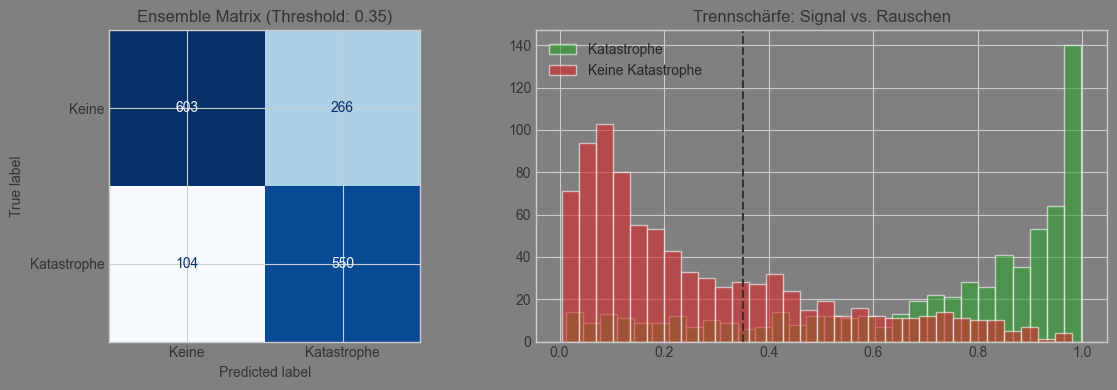


Finaler Status: Verpasste Katastrophen (FN) reduziert auf 104.

✅ Muster 2 (LLM + Noise-Filter) wurde erfolgreich berechnet.


In [19]:
# DER STARTKNOPF

# Falls das Modell gespeichert werden soll
BASE_MODEL_PATH = "ensemble_disaster_model.pkl"

# 1. Start der Pipeline für Muster 2
# Dieser Befehl nutzt deine 'def run_analysis' und füttert sie mit den Daten
final_model = run_analysis(
    X_train_classic=X_train_classic,
    y_train_classic=y_train_classic,
    X_test_classic=X_test_classic,
    y_test_classic=y_test_classic,
    stop_words_combined=stop_words_combined,
    colors=colors
)

# 2. Kurze Bestätigung
print("\n✅ Muster 2 (LLM + Noise-Filter) wurde erfolgreich berechnet.")

In [ ]:
# ANALYSE DER FEHLER (VOLLTEXT)
# Sicherstellen, dass die Daten für die Analyse aktuell berechnet sind
y_probs_test = base_model.predict_proba(X_test_classic[feature_cols])[:, 1]
y_pred_test = (y_probs_test >= custom_threshold).astype(int)
missed_mask = (y_test_classic == 1) & (y_pred_test == 0)

# df_missed erstellen mit den Begriffen aus Muster 2
df_missed = pd.DataFrame({
    'Text': X_test_classic.loc[missed_mask, 'lemmatized_text'],
    'Wahrscheinlichkeit': y_probs_test[missed_mask]
})

if not df_missed.empty:
    # Anzeige-Optionen anpassen: Volle Textbreite, keine Kürzung
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.max_rows', 100)

    print(f"\n### DETAILLIERTE FEHLER-ANALYSE ({len(df_missed)} Texte) ###")

    # Sortierung nach Wahrscheinlichkeit, um die knappsten Fehler oben zu sehen
    print(df_missed[['Text', 'Wahrscheinlichkeit']].sort_values(by='Wahrscheinlichkeit', ascending=False).to_string(index=False))

    # Optionen wieder zurücksetzen
    pd.reset_option('display.max_colwidth')
    pd.reset_option('display.max_rows')

    # Numerische Tabelle zur Unterstützung der Analyse (gemäß Vorgabe)
    print("\n### STATISTISCHE ZUSAMMENFASSUNG DER (FP) Katastrofen Die übersehen wurden sind ###")
    summary_data = {
        'Metrik': ['Anzahl verpasster Katastrophen', 'Höchste Fehler-Wahrscheinlichkeit'],
        'Wert': [len(df_missed),f"{df_missed['Wahrscheinlichkeit'].max():.4f}"]
    }
    print(pd.DataFrame(summary_data).to_string(index=True))
else:
    print("\n### Keine Fehler (FN) im aktuellen Test-Set gefunden. ###")

In [ ]:
# Kurze Analyse: Falscher Alarm (FP)
y_probs_test = base_model.predict_proba(X_test_classic[feature_cols])[:, 1]
fp_mask = (y_probs_test >= custom_threshold) & (y_test_classic == 0)

df_fp = pd.DataFrame({
    'Text': X_test_classic.loc[fp_mask, 'lemmatized_text'],
    'Wahrscheinlichkeit': y_probs_test[fp_mask]
})

if not df_fp.empty:
    pd.set_option('display.max_colwidth', None)
    print(f"\n### LISTE: FALSCHER ALARM (FP) ({len(df_fp)} Texte) ###")
    print(df_fp.sort_values(by='Wahrscheinlichkeit', ascending=False).to_string(index=False))

    # Numerische Tabelle (deine Vorgabe vom 29.10.)
    print("\n### ZUSAMMENFASSUNG der Nicht Katastrofen die als Katastrofe erksn wurden sind###")
    print(pd.DataFrame({'Metrik': ['Anzahl FP'], 'Wert': [len(df_fp)]}).to_string(index=False))

In [ ]:
# SCHRITT 7: SCATTERPLOT DER FEHLER
y_probs_test = base_model.predict_proba(X_test_classic[feature_cols])[:, 1]
y_pred_test = (y_probs_test >= custom_threshold).astype(int)

missed_mask = (y_test_classic == 1) & (y_pred_test == 0)
df_missed = X_test_classic[missed_mask]

if not df_missed.empty:
    print("\n STUDIE: VISUALISIERUNG DER FEHLER (SCATTERPLOT)")
    df_plot = pd.DataFrame({
        'Wahrscheinlichkeit': y_probs_test,
        'Subjektivität': X_test_classic['subjectivity'],
        'Klasse': y_test_classic.values,
        'Vorhersage': y_pred_test
    })
    conditions = [
        (df_plot['Klasse'] == 1) & (df_plot['Vorhersage'] == 0),
        (df_plot['Klasse'] == 0) & (df_plot['Vorhersage'] == 1)
    ]
    choices = ['Verpasste Katastrophe (FN)', 'Falscher Alarm (FP)']
    df_plot['Fehlertyp'] = np.select(conditions, choices, default='Korrekt erkannt')

    # Scatterplot erstellen
    fig, ax = plt.subplots(figsize=(10, 3))
    fig.patch.set_facecolor(colors['background'])
    ax.set_facecolor(colors['background'])
    # Wir plotten nur die Fehler, um die Übersicht zu behalten
    sns.scatterplot(
        data=df_plot[df_plot['Fehlertyp'] != 'Korrekt erkannt'],
        x='Wahrscheinlichkeit',
        y='Subjektivität',
        hue='Fehlertyp',
        palette={'Verpasste Katastrophe (FN)': colors['primary'], 'Falscher Alarm (FP)': colors['secondary']},
        alpha=0.5,
        s=30
    )

    plt.axvline(custom_threshold, color=colors['text'], linestyle='-.', label=f'Threshold {custom_threshold}')
    plt.title(f'Fehler-Analyse (Verpasste Fälle: {sum(missed_mask)})')
    plt.xlabel('Modell-Wahrscheinlichkeit')
    plt.ylabel('Subjektivität (TextBlob)')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.grid(True, alpha=0.1)
    plt.tight_layout()
    plt.show()

    # Numerische Ergebnistabelle (Deine Vorgabe)
    error_stats = df_plot['Fehlertyp'].value_counts().reset_index()
    error_stats.columns = ['Kategorie', 'Anzahl']
    print("\nStatistische Fehler-Verteilung:")
    print(error_stats.to_string(index=False))

- Erklärung zum Plot oben:
 - Punkte bei Subjektivität 0.0 (ganz unten) sind sachliche Texte ohne Gefühlsregungen.
 - Wenn dort viele blaue Punkte liegen, erkennt das Modell rein faktische Berichte
 - schlechter als emotionale Tweets. Die blauen Punkte links vom Threshold (0.35)
 - sind die Katastrophen, die wir komplett übersehen haben.

- Wert 0.0 (Objektiv): Der Text ist rein faktisch und neutral (z. B. „In Tokio gab es ein Erdbeben der Stärke 6.2“).

- Wert 1.0 (Subjektiv): Der Text ist stark von persönlichen Empfindungen, Meinungen oder emotionalen Ausdrücken geprägt
    - (z. B. „Das war das schrecklichste und furchtbarste Erlebnis meines Lebens“).

1. Orts- und Zeitbezug (NER - Named Entity Recognition)
Echte Katastrophenmeldungen enthalten fast immer konkrete geografische Angaben oder Zeitpunkte.

Der Ansatz: Mit Bibliotheken wie spaCy extrahierst du Orte (GPE).

Die Logik: Ein Tweet mit "Fire" ist vage. Ein Tweet mit "Fire" + "London" + "Uhrzeit" ist mit hoher Wahrscheinlichkeit ein echtes Ereignis.

2. Lexikalische Dichte und Wortarten (POS-Tagging)
Die Struktur eines Satzes verrät viel über die Absicht des Schreibers.

Der Ansatz: Analyse der Wortarten (Part-of-Speech).

Die Logik: Katastrophenmeldungen nutzen oft mehr Substantive (Fakten) und Verben im Perfekt/Präteritum (etwas ist passiert). Nicht-Katastrophen (Meinungen/Sarkasmus) nutzen oft mehr Adjektive und Pronomen ("ich", "mein", "schrecklich").

3. Keyword-Exklusivität (TF-IDF Optimierung)
Du nutzt bereits TF-IDF, aber man kann die "Wichtigkeit" von Wörtern noch schärfer trennen.

Der Ansatz: Wörter, die in beiden Kategorien vorkommen (z.B. "Hilfe"), erhalten ein geringeres Gewicht.

Die Logik: Wörter wie "Erdbeben" oder "Evakuierung" sind exklusiv für Katastrophen. Wörter wie "heiß" können sowohl Wetter als auch ein "heißes Video" meinen. Das Modell lernt, exklusive Begriffe höher zu bewerten.

## Ansatz 2: Systematischer Vergleich & Optimierung klassischer Modelle auf Recall
### Schritt 2a: Schneller Vergleich verschiedener Modell-Pipelines

In [ ]:
if 'X_train_classic' in locals():
    preprocessor = ColumnTransformer([
        ('tfidf', TfidfVectorizer(stop_words=list(stop_words_combined)), 'cleaned_text'), # Verwende kombinierte Stoppwörter
        ('caps', UppercaseWordCount(), 'text')],
        remainder='drop')

    pipelines = {
        "LogisticRegression": Pipeline([('features', preprocessor), ('clf', LogisticRegression(max_iter=5000, class_weight="balanced", solver="liblinear"))]),
        "LinearSVC": Pipeline([('features', preprocessor), ('clf', LinearSVC(class_weight="balanced", dual=False, max_iter=2000))]),
        "RandomForest": Pipeline([('features', preprocessor), ('clf', RandomForestClassifier(n_estimators=200, class_weight="balanced", n_jobs=-1))])
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scoring = {'recall': 'recall', 'f1_macro': 'f1_macro'}
    results = []

    print("Starte schnellen Modellvergleich via 5-facher Kreuzvalidierung...")
    for name, pipe in tqdm(pipelines.items(), desc="Modellvergleich"):
        out = cross_validate(pipe, X_train_classic, y_train_classic, cv=cv, scoring=scoring, n_jobs=-1)
        row = {"model": name}
        for k, v in out.items():
            if k.startswith("test_"):
                row[k.replace("test_", "")] = float(np.mean(v))
        results.append(row)

    res_df = pd.DataFrame(results).sort_values("recall", ascending=False)
    print("\n--- Ergebnisse des Modellvergleichs (sortiert nach Recall) ---")
    display(res_df)
    best_model_name = res_df.iloc[0]["model"]
    print(f"🏆 Bestes Modell für Recall laut Kreuzvalidierung: {best_model_name}")



### Schritt 2b: Gezieltes Hyperparameter-Tuning des besten Modells auf Recall

In [ ]:
if 'best_model_name' in locals():
    # --- 1. MODELL-LADEN ODER TUNING ---
    if os.path.exists(BEST_CLASSIC_MODEL_PATH):
        print(f"✅ Lade optimiertes Modell: {best_model_name}")
        best_classic_model = joblib.load(BEST_CLASSIC_MODEL_PATH)
    else:
        print(f"🚀 Starte Hyperparameter-Tuning für: {best_model_name}")
        best_pipe = pipelines[best_model_name]

        param_grids = {
            "LogisticRegression": {'features__tfidf__max_features': [15000, 20000], 'clf__C': [0.5, 1.0, 2.0]},
            "LinearSVC": {'features__tfidf__max_features': [15000, 20000], 'clf__C': [0.1, 1.0, 10.0]},
            "RandomForest": {'features__tfidf__max_features': [5000, 10000], 'clf__n_estimators': [300, 500]}
        }

        param_grid = param_grids.get(best_model_name, {})
        n_splits = 3
        total_fits = np.prod([len(v) for v in param_grid.values()]) * n_splits

        with tqdm_joblib(tqdm(total=total_fits, desc="GridSearchCV Progress", bar_format='{l_bar}{bar:20}{r_bar}')):
            grid_search = GridSearchCV(best_pipe, param_grid, cv=n_splits, n_jobs=-1, scoring='recall')
            grid_search.fit(X_train_classic, y_train_classic)

        best_classic_model = grid_search.best_estimator_
        joblib.dump(best_classic_model, BEST_CLASSIC_MODEL_PATH)

    # --- 2. DATEN-VORSCHAU & PERFORMANCE-BERECHNUNG ---
    y_pred = best_classic_model.predict(X_test_classic)

    # Wahrscheinlichkeiten sicherstellen (Handle LinearSVC)
    if hasattr(best_classic_model, "predict_proba"):
        y_probs = best_classic_model.predict_proba(X_test_classic)[:, 1]
    else:
        # Fallback für Modelle ohne Wahrscheinlichkeiten
        d_func = best_classic_model.decision_function(X_test_classic)
        y_probs = (d_func - d_func.min()) / (d_func.max() - d_func.min())

    # --- 3. VISUALISIERUNG (SAUBERES DASHBOARD) ---
    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    fig.patch.set_facecolor(colors['background']) # Globaler Hintergrund

    # Plot A: Konfusionsmatrix
    cm = confusion_matrix(y_test_classic, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Keine', 'Katastrophe'])
    disp.plot(cmap='Blues', ax=ax[0], colorbar=False)
    ax[0].set_title(f'Konfusionsmatrix: {best_model_name}', color=colors['text'], pad=20)

    # Plot B: Signal-Verteilung (Einheitliche Farben)
    ax[1].hist(y_probs[y_test_classic == 1], bins=35, alpha=0.7,
               label='Echte Katastrophe', color=colors['success'], edgecolor='white')
    ax[1].hist(y_probs[y_test_classic == 0], bins=35, alpha=0.5,
               label='Normal', color=colors['error'], edgecolor='white')

    ax[1].set_title('Trennschärfe: Signal vs. Rauschen', color=colors['text'], pad=20)
    ax[1].legend(facecolor=colors['background'], edgecolor=colors['text'])

    # Gemeinsames Styling für beide Subplots
    for a in ax:
        a.set_facecolor(colors['background'])
        a.tick_params(colors=colors['text'])
        for spine in a.spines.values():
            spine.set_edgecolor(colors.get('grid', '#888888'))
        a.xaxis.label.set_color(colors['text'])
        a.yaxis.label.set_color(colors['text'])

    plt.tight_layout()
    plt.show()

    # --- 4. NUMERISCHE UNTERSTÜTZUNG (TABELLE) ---
    print(f"\n### PERFORMANCE-REPORT: {best_model_name} ###")
    report_df = pd.DataFrame(classification_report(y_test_classic, y_pred, output_dict=True)).transpose().round(3)
    display(report_df)

    # Zusammenfassung der Fehlerraten
    fn = cm[1, 0]
    fp = cm[0, 1]
    print(f"\nErgebnis-Check: {fn} Katastrophen übersehen (FN), {fp} Fehlalarme (FP).")

## Ansatz 3: Moderner Ansatz (Fine-Tuning eines Transformer-Modells) - Recall-optimiert

In [ ]:
if 'X_train_orig' in locals():
    if os.path.exists(KERAS_MODEL_PATH):
        print("Lade existierendes Keras-Modell...")
        classifier = tf.keras.models.load_model(KERAS_MODEL_PATH)
        print("✅ Keras-Modell geladen.")
    else:
        print("\nTrainiere neues Keras-Modell (Fine-Tuning)...")
        classifier = keras_nlp.models.DistilBertClassifier.from_preset("distil_bert_base_en_uncased", num_classes=2)
        classifier.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(3e-5), metrics=["accuracy"])

        early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

        # Berechne Klassengewichte für den Transformer
        class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_orig), y=y_train_orig)
        class_weight_dict = dict(enumerate(class_weights))

        history = classifier.fit(x=X_train_orig, y=y_train_orig, batch_size=16, epochs=5,
                                 validation_data=(X_test_orig, y_test_orig),
                                 callbacks=[TqdmCallback(verbose=2), early_stopping],
                                 class_weight=class_weight_dict, # Fokus auf Recall
                                 verbose=0)
        classifier.save(KERAS_MODEL_PATH)
        print(f"✅ Modell gespeichert unter: {KERAS_MODEL_PATH}")

    print("\n--- Ergebnisse des KerasNLP/DistilBERT-Modells ---")
    y_pred_bert_logits = classifier.predict(X_test_orig, verbose=0)
    y_pred_bert = np.argmax(y_pred_bert_logits, axis=1)
    print(classification_report(y_test_orig, y_pred_bert, target_names=['Keine Katastrophe', 'Katastrophe']))
    ConfusionMatrixDisplay.from_predictions(y_test_orig, y_pred_bert, display_labels=['Keine Katastrophe', 'Katastrophe'], cmap='Blues').plot()
    plt.title('Konfusionsmatrix (KerasNLP/DistilBERT)')
    plt.show()
